<a href="https://colab.research.google.com/github/rafisembiring/Tugas2/blob/main/Artisign_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Artisign
###Penerjemah Bahasa Isyarat Indonesia

## 1. Setup dan Import Library yang Diperlukan

In [ ]:
# 1. First clean up existing installations
!pip uninstall -y mediapipe numpy opencv-python
!pip cache purge

# 2. Install compatible versions
!pip install numpy==1.26.4  # Newer NumPy that works with Python 3.11
!pip install mediapipe==0.10.21  # Latest available version
!pip install opencv-python==4.9.0.80
!pip install gradio flask

# 3. Verify installation
import numpy as np
import mediapipe as mp
import cv2

print("NumPy:", np.__version__)
print("MediaPipe:", mp.__version__)
print("OpenCV:", cv2.__version__)

NumPy: 1.26.4
MediaPipe: 0.10.21
OpenCV: 4.9.0


In [ ]:
import os
import numpy as np
import cv2
import mediapipe as mp
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, LSTM, TimeDistributed, Input, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications import MobileNetV2, EfficientNetB0
from keras.optimizers import Adam
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import zipfile
import gradio as gr
import json
import time
from glob import glob
from tqdm.notebook import tqdm

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU tersedia untuk digunakan")
else:
    print("GPU tidak tersedia, menggunakan CPU")

GPU tersedia untuk digunakan


## 2. Download dan Persiapkan Dataset

In [ ]:
# Untuk menggunakan Kaggle API, upload file kaggle.json Anda di sini
# atau gunakan metode yang sesuai untuk mengakses dataset Kaggle

# Buat direktori untuk menyimpan kredensial Kaggle
!mkdir -p ~/.kaggle

# Alternatif: Upload kaggle.json secara manual dan salin ke folder .kaggle
from google.colab import files
uploaded = files.upload()
!cp kaggle.json ~/.kaggle/

# Atur permission file kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset gambar dan video
# Dataset 1: Indonesian Sign Language (BISINDO) - Gambar Statis
!kaggle datasets download -d agungmrf/indonesian-sign-language-bisindo
!unzip -q indonesian-sign-language-bisindo.zip -d bisindo_image_dataset

# Dataset 2: BISINDO 40 Kata (MP4) - Video Dinamis
!kaggle datasets download -d anggiyohanespardede/bisindo-40-kata-mp4
!unzip -q bisindo-40-kata-mp4.zip -d bisindo_video_dataset

# Eksplorasi struktur dataset
print("Struktur dataset gambar:")
!ls -la bisindo_image_dataset

print("\nStruktur dataset video:")
!ls -la bisindo_video_dataset

# Buat mapping kata-kata dalam dataset
# Untuk dataset gambar
image_classes = sorted(os.listdir('bisindo_image_dataset/bisindo/images/train'))
image_classes_map = {cls: i for i, cls in enumerate(image_classes)}
print(f"Jumlah kelas dalam dataset gambar: {len(image_classes)}")
print(f"Kelas dalam dataset gambar: {image_classes}")

# Untuk dataset video
video_classes = sorted(os.listdir('bisindo_video_dataset/raw_video'))
video_classes_map = {cls: i for i, cls in enumerate(video_classes)}
print(f"Jumlah kelas dalam dataset video: {len(video_classes)}")
print(f"Kelas dalam dataset video: {video_classes}")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/agungmrf/indonesian-sign-language-bisindo
License(s): unknown
 99% 1.35G/1.36G [00:01<00:00, 889MB/s]
100% 1.36G/1.36G [00:01<00:00, 920MB/s]
Dataset URL: https://www.kaggle.com/datasets/anggiyohanespardede/bisindo-40-kata-mp4
License(s): MIT
 92% 659M/719M [00:00<00:00, 1.15GB/s]
100% 719M/719M [00:00<00:00, 1.03GB/s]
Struktur dataset gambar:
total 12
drwxr-xr-x 3 root root 4096 May 15 03:35 .
drwxr-xr-x 1 root root 4096 May 15 03:35 ..
drwxr-xr-x 4 root root 4096 May 15 03:35 bisindo

Struktur dataset video:
total 12
drwxr-xr-x  3 root root 4096 May 15 03:35 .
drwxr-xr-x  1 root root 4096 May 15 03:35 ..
drwxr-xr-x 42 root root 4096 May 15 03:35 raw_video
Jumlah kelas dalam dataset gambar: 26
Kelas dalam dataset gambar: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Jumlah kelas dalam dataset video: 40
Kelas dalam dataset v

## 3. Preprocessing Data dan Ekstraksi Fitur

Memulai preprocessing dataset gambar...


  0%|          | 0/26 [00:00<?, ?it/s]

Dataset gambar setelah preprocessing: 7969 sampel dengan 26 kelas

Memulai preprocessing dataset video...


  0%|          | 0/40 [00:00<?, ?it/s]

Dataset video setelah preprocessing: 2000 sampel dengan 40 kelas


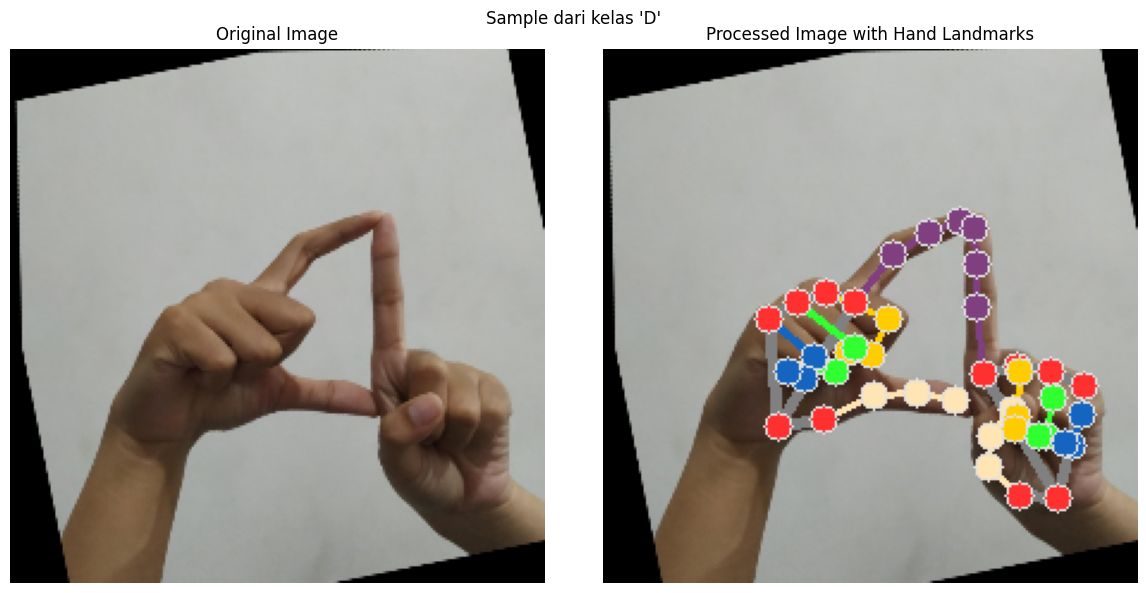

In [ ]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# 3.1 Fungsi untuk ekstraksi landmark tangan
def extract_hand_landmarks(image, hands_detector):
    """
    Ekstrak landmark tangan dari sebuah gambar

    Args:
        image: Gambar input (BGR)
        hands_detector: MediaPipe hands detector

    Returns:
        landmarks_list: List landmark tangan (jika terdeteksi)
        processed_image: Gambar dengan visualisasi landmark
    """
    # Konversi ke RGB untuk MediaPipe
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    # Proses deteksi tangan
    results = hands_detector.process(image_rgb)

    # Copy gambar untuk visualisasi
    processed_image = image.copy()

    landmarks_list = []

    # Cek apakah tangan terdeteksi
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Visualisasi landmark pada gambar
            mp_drawing.draw_landmarks(
                processed_image,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style()
            )

            # Ekstrak koordinat landmark (21 titik per tangan)
            landmarks = []
            for landmark in hand_landmarks.landmark:
                # Normalisasi koordinat relatif terhadap ukuran gambar
                landmarks.extend([landmark.x, landmark.y, landmark.z])

            landmarks_list.append(landmarks)

    return landmarks_list, processed_image

# 3.2 Preprocessing untuk Dataset Gambar
def preprocess_image_dataset(dataset_path, target_size=(224, 224), max_samples_per_class=500):
    """
    Preprocess dataset gambar dan ekstrak fitur landmark tangan

    Args:
        dataset_path: Path ke dataset gambar
        target_size: Ukuran gambar yang diinginkan untuk model
        max_samples_per_class: Jumlah maksimum sampel per kelas

    Returns:
        X_landmarks: Fitur landmark tangan
        X_images: Gambar yang sudah dipreprocessing
        y: Label kelas
        class_names: Nama kelas
    """
    X_landmarks = []
    X_images = []
    y = []
    class_names = []

    # Inisialisasi MediaPipe Hands
    with mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=2,
        min_detection_confidence=0.5) as hands:

        # Untuk setiap kelas dalam dataset
        classes = sorted(os.listdir(os.path.join(dataset_path, '/content/bisindo_image_dataset/bisindo/images/train')))

        for class_idx, class_name in enumerate(tqdm(classes)):
            class_names.append(class_name)
            class_path = os.path.join(dataset_path, '/content/bisindo_image_dataset/bisindo/images/train', class_name)

            # Ambil semua file gambar
            image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

            # Batasi jumlah sampel per kelas
            if len(image_files) > max_samples_per_class:
                image_files = image_files[:max_samples_per_class]

            for img_file in image_files:
                img_path = os.path.join(class_path, img_file)

                # Baca gambar
                image = cv2.imread(img_path)
                if image is None:
                    continue

                # Resize gambar
                image = cv2.resize(image, target_size)

                # Ekstrak landmark tangan
                landmarks_list, processed_image = extract_hand_landmarks(image, hands)

                if landmarks_list:
                    # Gunakan landmark pertama jika ada
                    # Normalisasi landmark untuk fitur
                    X_landmarks.append(landmarks_list[0])  # 21 landmark x 3 (x,y,z) = 63 fitur

                    # Normalisasi gambar
                    norm_image = image / 255.0
                    X_images.append(norm_image)

                    # Label kelas
                    y.append(class_idx)

    # Konversi ke numpy array
    X_landmarks = np.array(X_landmarks)
    X_images = np.array(X_images)
    y = np.array(y)

    print(f"Dataset gambar setelah preprocessing: {len(X_landmarks)} sampel dengan {len(class_names)} kelas")

    return X_landmarks, X_images, y, class_names

# 3.3 Preprocessing untuk Dataset Video
def preprocess_video_dataset(dataset_path, num_frames=30, target_size=(224, 224), max_videos_per_class=50):
    """
    Preprocess dataset video dan ekstrak sequence landmark tangan

    Args:
        dataset_path: Path ke dataset video
        num_frames: Jumlah frame yang diekstrak per video
        target_size: Ukuran frame yang diinginkan
        max_videos_per_class: Jumlah maksimum video per kelas

    Returns:
        X_video_sequences: Sequence fitur landmark tangan dari video
        X_frames: Sample frame video yang sudah dipreprocessing
        y_video: Label kelas
        video_class_names: Nama kelas
    """
    X_video_sequences = []
    X_frames = []  # Sample frame untuk visualisasi
    y_video = []
    video_class_names = []

    # Inisialisasi MediaPipe Hands
    with mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=2,
        min_detection_confidence=0.5) as hands:

        # Untuk setiap kelas dalam dataset video
        classes = sorted(os.listdir(os.path.join(dataset_path, '/content/bisindo_video_dataset/raw_video')))

        for class_idx, class_name in enumerate(tqdm(classes)):
            video_class_names.append(class_name)
            class_path = os.path.join(dataset_path, '/content/bisindo_video_dataset/raw_video', class_name)

            # Ambil semua file video
            video_files = [f for f in os.listdir(class_path) if f.endswith(('.mp4', '.avi', '.mov'))]

            # Batasi jumlah video per kelas
            if len(video_files) > max_videos_per_class:
                video_files = video_files[:max_videos_per_class]

            for video_file in video_files:
                video_path = os.path.join(class_path, video_file)

                # Buka video
                cap = cv2.VideoCapture(video_path)

                if not cap.isOpened():
                    print(f"Error membuka video: {video_path}")
                    continue

                # Hitung jumlah frame dan durasi video
                total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                fps = cap.get(cv2.CAP_PROP_FPS)

                # Hitung interval untuk mengambil frame (distribusi merata)
                if total_frames <= num_frames:
                    frame_indices = range(total_frames)
                else:
                    frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)

                # Ekstrak landmark dari setiap frame yang dipilih
                video_landmarks_sequence = []
                sample_frame = None

                for frame_idx in range(total_frames):
                    ret, frame = cap.read()

                    if not ret:
                        break

                    if frame_idx in frame_indices:
                        # Resize frame
                        frame = cv2.resize(frame, target_size)

                        # Simpan frame pertama untuk visualisasi
                        if sample_frame is None:
                            sample_frame = frame.copy()

                        # Ekstrak landmark
                        landmarks_list, _ = extract_hand_landmarks(frame, hands)

                        if landmarks_list:
                            # Gunakan landmark tangan pertama
                            video_landmarks_sequence.append(landmarks_list[0])
                        else:
                            # Jika tidak ada landmark terdeteksi, gunakan zeros
                            video_landmarks_sequence.append(np.zeros(63))  # 21 landmark x 3 (x,y,z)

                cap.release()

                # Pastikan sequence memiliki panjang yang sama dengan num_frames
                if len(video_landmarks_sequence) < num_frames:
                    # Padding sequence jika kurang dari num_frames
                    padding = [np.zeros(63) for _ in range(num_frames - len(video_landmarks_sequence))]
                    video_landmarks_sequence.extend(padding)
                elif len(video_landmarks_sequence) > num_frames:
                    video_landmarks_sequence = video_landmarks_sequence[:num_frames]

                # Tambahkan ke dataset
                if sample_frame is not None:
                    X_video_sequences.append(video_landmarks_sequence)
                    X_frames.append(sample_frame / 255.0)  # Normalisasi
                    y_video.append(class_idx)

    # Konversi ke numpy array
    X_video_sequences = np.array(X_video_sequences)
    X_frames = np.array(X_frames)
    y_video = np.array(y_video)

    print(f"Dataset video setelah preprocessing: {len(X_video_sequences)} sampel dengan {len(video_class_names)} kelas")

    return X_video_sequences, X_frames, y_video, video_class_names

# 3.4 Visualisasi Hasil Preprocessing
def visualize_preprocessing(sample_image, processed_image, landmarks=None, title="Sample Preprocessing"):
    """
    Visualisasi hasil preprocessing

    Args:
        sample_image: Gambar asli
        processed_image: Gambar setelah preprocessing
        landmarks: (optional) Landmark tangan untuk visualisasi
        title: Judul visualisasi
    """
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
    plt.title("Processed Image with Hand Landmarks")
    plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Jalankan preprocessing
print("Memulai preprocessing dataset gambar...")
X_landmarks, X_images, y, class_names = preprocess_image_dataset('bisindo_image_dataset')

print("\nMemulai preprocessing dataset video...")
X_video_sequences, X_frames, y_video, video_class_names = preprocess_video_dataset('bisindo_video_dataset')

# Visualisasi contoh hasil preprocessing
if len(X_images) > 0:
    idx = np.random.randint(0, len(X_images))
    sample_img = (X_images[idx] * 255).astype(np.uint8)

    with mp_hands.Hands(static_image_mode=True, max_num_hands=2) as hands:
        landmarks_list, processed_img = extract_hand_landmarks(sample_img, hands)

    visualize_preprocessing(sample_img, processed_img,
                          title=f"Sample dari kelas '{class_names[y[idx]]}'")

# One-hot encoding untuk label
y_onehot = to_categorical(y, num_classes=len(class_names))
y_video_onehot = to_categorical(y_video, num_classes=len(video_class_names))

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_images, y_onehot, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)  # 10% dari total

X_landmarks_train, X_landmarks_test, y_landmarks_train, y_landmarks_test = train_test_split(
    X_landmarks, y_onehot, test_size=0.2, random_state=42)
X_landmarks_train, X_landmarks_val, y_landmarks_train, y_landmarks_val = train_test_split(
    X_landmarks_train, y_landmarks_train, test_size=0.125, random_state=42)

# Split untuk dataset video
X_video_train, X_video_test, y_video_train, y_video_test = train_test_split(
    X_video_sequences, y_video_onehot, test_size=0.2, random_state=42)
X_video_train, X_video_val, y_video_train, y_video_val = train_test_split(
    X_video_train, y_video_train, test_size=0.125, random_state=42)

# Simpan mapping kelas untuk digunakan dalam inferensi
class_mapping = {i: name for i, name in enumerate(class_names)}
video_class_mapping = {i: name for i, name in enumerate(video_class_names)}

with open('image_class_mapping.json', 'w') as f:
    json.dump(class_mapping, f)

with open('video_class_mapping.json', 'w') as f:
    json.dump(video_class_mapping, f)

## 4. Pembuatan Model

In [ ]:
# 4.1 Model CNN untuk Gambar (Pilihan 1)
def create_image_cnn_model(input_shape=(224, 224, 3), num_classes=len(class_names)):
    """
    Buat model CNN untuk klasifikasi gambar menggunakan arsitektur MobileNetV2

    Args:
        input_shape: Bentuk input gambar
        num_classes: Jumlah kelas output

    Returns:
        model: Model Keras yang sudah dikompilasi
    """
    # Base model menggunakan MobileNetV2
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Freeze beberapa layer base model
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Buat model dengan tambahan layer untuk klasifikasi
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    # Kompilasi model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# 4.2 Model untuk landmark tangan
def create_landmark_model(input_shape=(63,), num_classes=len(class_names)):
    """
    Buat model MLP untuk klasifikasi berdasarkan landmark tangan

    Args:
        input_shape: Bentuk input landmark
        num_classes: Jumlah kelas output

    Returns:
        model: Model Keras yang sudah dikompilasi
    """
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# 4.3 Model Hybrid CNN+LSTM untuk Video
def create_video_model(input_shape=(30, 63), num_classes=len(video_class_names)):
    """
    Buat model hybrid CNN+LSTM untuk klasifikasi video

    Args:
        input_shape: Bentuk input sequence landmark
        num_classes: Jumlah kelas output

    Returns:
        model: Model Keras yang sudah dikompilasi
    """
    model = Sequential([
        # LSTM layers untuk sequence data
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(256, return_sequences=False),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Buat ketiga model
print("Membuat model CNN untuk gambar...")
image_model = create_image_cnn_model(input_shape=(224, 224, 3), num_classes=len(class_names))
image_model.summary()

print("\nMembuat model landmark...")
landmark_model = create_landmark_model(input_shape=(63,), num_classes=len(class_names))
landmark_model.summary()

print("\nMembuat model video...")
video_model = create_video_model(input_shape=(30, 63), num_classes=len(video_class_names))
video_model.summary()

Membuat model CNN untuk gambar...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,051,866 (11.64 MB)

 Trainable params: 2,655,322 (10.13 MB)

 Non-trainable params: 396,544 (1.51 MB)


Membuat model landmark...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,466 (302.60 KB)

 Trainable params: 77,466 (302.60 KB)

 Non-trainable params: 0 (0.00 B)


Membuat model video...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        98,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 530,600 (2.02 MB)

 Trainable params: 530,600 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Training Model

In [ ]:
# 5.1 Callbacks untuk training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# 5.2 Training Model CNN untuk Gambar
image_model_checkpoint = ModelCheckpoint(
    'best_image_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

print("Training model CNN untuk gambar...")
image_history = image_model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, image_model_checkpoint]
)

# 5.3 Training Model Landmark
landmark_model_checkpoint = ModelCheckpoint(
    'best_landmark_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

print("\nTraining model landmark...")
landmark_history = landmark_model.fit(
    X_landmarks_train,
    y_landmarks_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_landmarks_val, y_landmarks_val),
    callbacks=[early_stopping, reduce_lr, landmark_model_checkpoint]
)

# 5.4 Training Model Video
video_model_checkpoint = ModelCheckpoint(
    'best_video_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

print("\nTraining model video...")
video_history = video_model.fit(
    X_video_train,
    y_video_train,
    batch_size=16,
    epochs=50,
    validation_data=(X_video_val, y_video_val),
    callbacks=[early_stopping, reduce_lr, video_model_checkpoint]
)

Training model CNN untuk gambar...
Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6305 - loss: 1.3333
Epoch 1: val_accuracy improved from -inf to 0.38269, saving model to best_image_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 60s 179ms/step - accuracy: 0.6314 - loss: 1.3299 - val_accuracy: 0.3827 - val_loss: 6.1124 - learning_rate: 0.0010
Epoch 2/50
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9423 - loss: 0.2203
Epoch 2: val_accuracy did not improve from 0.38269
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9422 - loss: 0.2203 - val_accuracy: 0.1932 - val_loss: 10.7761 - learning_rate: 0.0010
Epoch 3/50
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9324 - loss: 0.2774
Epoch 3: val_accuracy did not improve from 0.38269
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9327 - loss: 0.2762 - val_accuracy: 0.1895 - val_loss: 12.9847 - learning_rate: 0.0010
Epoch 4/50
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9707 - loss: 0.1169
Epoch 4: val_accuracy did not improve from 0.38269
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9706 - loss: 0.1171 - val_accuracy: 0.1606 - val_loss: 9.8715 - learning_rate: 0.0010
Epoch 5/50
173

175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9769 - loss: 0.0907 - val_accuracy: 0.4153 - val_loss: 5.0095 - learning_rate: 0.0010
Epoch 10/50
174/175 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9861 - loss: 0.0575
Epoch 10: val_accuracy did not improve from 0.41531
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9861 - loss: 0.0576 - val_accuracy: 0.3024 - val_loss: 9.7567 - learning_rate: 0.0010
Epoch 11/50
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9806 - loss: 0.1022
Epoch 11: val_accuracy did not improve from 0.41531
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9806 - loss: 0.1021 - val_accuracy: 0.1581 - val_loss: 11.8710 - learning_rate: 0.0010
Epoch 12/50
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9861 - loss: 0.0697
Epoch 12: val_accuracy improved from 0.41531 to 0.54705, saving model to best_image_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9862 - loss: 0.0692 - val_accuracy: 0.5471 - val_loss: 2.0511 - learning_rate: 0.0010
Epoch 13/50
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9814 - loss: 0.0858
Epoch 13: val_accuracy did not improve from 0.54705
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9815 - loss: 0.0858 - val_accuracy: 0.4655 - val_loss: 3.9457 - learning_rate: 0.0010
Epoch 14/50
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9785 - loss: 0.1097
Epoch 14: val_accuracy did not improve from 0.54705
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9786 - loss: 0.1091 - val_accuracy: 0.2459 - val_loss: 15.3830 - learning_rate: 0.0010
Epoch 15/50
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9903 - loss: 0.0385
Epoch 15: val_accuracy did not improve from 0.54705
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9903 - loss: 0.0384 - val_accuracy: 0.1669 - val_loss: 19.3423 - learning_rate: 0.0010
Epoch 16/5

175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9952 - loss: 0.0215 - val_accuracy: 0.5696 - val_loss: 4.0957 - learning_rate: 0.0010
Epoch 18/50
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9992 - loss: 0.0038
Epoch 18: val_accuracy improved from 0.56964 to 0.81430, saving model to best_image_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9992 - loss: 0.0038 - val_accuracy: 0.8143 - val_loss: 1.4433 - learning_rate: 2.0000e-04
Epoch 19/50
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9998 - loss: 8.2866e-04
Epoch 19: val_accuracy improved from 0.81430 to 0.94856, saving model to best_image_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9997 - loss: 8.3160e-04 - val_accuracy: 0.9486 - val_loss: 0.2385 - learning_rate: 2.0000e-04
Epoch 20/50
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9997 - loss: 0.0011
Epoch 20: val_accuracy improved from 0.94856 to 0.98620, saving model to best_image_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 0.9862 - val_loss: 0.0489 - learning_rate: 2.0000e-04
Epoch 21/50
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 2.8476e-04
Epoch 21: val_accuracy improved from 0.98620 to 0.99498, saving model to best_image_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 1.0000 - loss: 2.8497e-04 - val_accuracy: 0.9950 - val_loss: 0.0217 - learning_rate: 2.0000e-04
Epoch 22/50
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 3.6839e-04
Epoch 22: val_accuracy improved from 0.99498 to 0.99875, saving model to best_image_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 1.0000 - loss: 3.6807e-04 - val_accuracy: 0.9987 - val_loss: 0.0103 - learning_rate: 2.0000e-04
Epoch 23/50
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 5.4034e-04
Epoch 23: val_accuracy did not improve from 0.99875
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 1.0000 - loss: 5.4192e-04 - val_accuracy: 0.9987 - val_loss: 0.0052 - learning_rate: 2.0000e-04
Epoch 24/50
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 4.5672e-04
Epoch 24: val_accuracy did not improve from 0.99875
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 1.0000 - loss: 4.6170e-04 - val_accuracy: 0.9987 - val_loss: 0.0017 - learning_rate: 2.0000e-04
Epoch 25/50
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9998 - loss: 6.5153e-04
Epoch 25: val_accuracy improved from 0.99875 to 1.00000, saving model to best_image_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9998 - loss: 6.5035e-04 - val_accuracy: 1.0000 - val_loss: 9.1266e-04 - learning_rate: 2.0000e-04
Epoch 26/50
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 1.4920e-04
Epoch 26: val_accuracy did not improve from 1.00000
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 1.0000 - loss: 1.5060e-04 - val_accuracy: 1.0000 - val_loss: 8.7439e-04 - learning_rate: 2.0000e-04
Epoch 27/50
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 1.0154e-04
Epoch 27: val_accuracy did not improve from 1.00000
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 1.0000 - loss: 1.0235e-04 - val_accuracy: 1.0000 - val_loss: 6.5426e-04 - learning_rate: 2.0000e-04
Epoch 28/50
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 2.8680e-04
Epoch 28: val_accuracy did not improve from 1.00000
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 1.0000 - loss: 2.8563e-04 - val_accuracy: 1.0000 - v

175/175 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.0777 - loss: 3.1647 - val_accuracy: 0.3388 - val_loss: 2.3271 - learning_rate: 0.0010
Epoch 2/50
169/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3009 - loss: 2.3069
Epoch 2: val_accuracy improved from 0.33877 to 0.51066, saving model to best_landmark_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3025 - loss: 2.3008 - val_accuracy: 0.5107 - val_loss: 1.7171 - learning_rate: 0.0010
Epoch 3/50
167/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4188 - loss: 1.8159
Epoch 3: val_accuracy improved from 0.51066 to 0.60853, saving model to best_landmark_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4203 - loss: 1.8123 - val_accuracy: 0.6085 - val_loss: 1.3786 - learning_rate: 0.0010
Epoch 4/50
167/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5125 - loss: 1.5335
Epoch 4: val_accuracy improved from 0.60853 to 0.67629, saving model to best_landmark_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5129 - loss: 1.5319 - val_accuracy: 0.6763 - val_loss: 1.1568 - learning_rate: 0.0010
Epoch 5/50
167/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5713 - loss: 1.3792
Epoch 5: val_accuracy improved from 0.67629 to 0.70263, saving model to best_landmark_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5714 - loss: 1.3779 - val_accuracy: 0.7026 - val_loss: 1.0092 - learning_rate: 0.0010
Epoch 6/50
165/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6069 - loss: 1.2523
Epoch 6: val_accuracy improved from 0.70263 to 0.74529, saving model to best_landmark_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6069 - loss: 1.2514 - val_accuracy: 0.7453 - val_loss: 0.8906 - learning_rate: 0.0010
Epoch 7/50
158/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6324 - loss: 1.1650
Epoch 7: val_accuracy did not improve from 0.74529
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6326 - loss: 1.1635 - val_accuracy: 0.7378 - val_loss: 0.8846 - learning_rate: 0.0010
Epoch 8/50
160/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6502 - loss: 1.0868
Epoch 8: val_accuracy improved from 0.74529 to 0.78670, saving model to best_landmark_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6512 - loss: 1.0858 - val_accuracy: 0.7867 - val_loss: 0.7832 - learning_rate: 0.0010
Epoch 9/50
160/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6752 - loss: 1.0530
Epoch 9: val_accuracy did not improve from 0.78670
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6758 - loss: 1.0504 - val_accuracy: 0.7842 - val_loss: 0.7406 - learning_rate: 0.0010
Epoch 10/50
164/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6939 - loss: 0.9622
Epoch 10: val_accuracy improved from 0.78670 to 0.80301, saving model to best_landmark_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6944 - loss: 0.9621 - val_accuracy: 0.8030 - val_loss: 0.6860 - learning_rate: 0.0010
Epoch 11/50
167/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7196 - loss: 0.9008
Epoch 11: val_accuracy did not improve from 0.80301
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7196 - loss: 0.9002 - val_accuracy: 0.8018 - val_loss: 0.6899 - learning_rate: 0.0010
Epoch 12/50
165/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7119 - loss: 0.9004
Epoch 12: val_accuracy improved from 0.80301 to 0.80928, saving model to best_landmark_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7126 - loss: 0.8992 - val_accuracy: 0.8093 - val_loss: 0.6495 - learning_rate: 0.0010
Epoch 13/50
169/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7490 - loss: 0.8256
Epoch 13: val_accuracy did not improve from 0.80928
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7488 - loss: 0.8257 - val_accuracy: 0.7967 - val_loss: 0.6738 - learning_rate: 0.0010
Epoch 14/50
164/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7352 - loss: 0.8188
Epoch 14: val_accuracy improved from 0.80928 to 0.82183, saving model to best_landmark_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7358 - loss: 0.8182 - val_accuracy: 0.8218 - val_loss: 0.6130 - learning_rate: 0.0010
Epoch 15/50
169/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7656 - loss: 0.7700
Epoch 15: val_accuracy improved from 0.82183 to 0.83312, saving model to best_landmark_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7654 - loss: 0.7705 - val_accuracy: 0.8331 - val_loss: 0.5869 - learning_rate: 0.0010
Epoch 16/50
168/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7775 - loss: 0.7286
Epoch 16: val_accuracy improved from 0.83312 to 0.83940, saving model to best_landmark_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7771 - loss: 0.7302 - val_accuracy: 0.8394 - val_loss: 0.5930 - learning_rate: 0.0010
Epoch 17/50
169/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7598 - loss: 0.7634
Epoch 17: val_accuracy improved from 0.83940 to 0.84944, saving model to best_landmark_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7602 - loss: 0.7625 - val_accuracy: 0.8494 - val_loss: 0.5494 - learning_rate: 0.0010
Epoch 18/50
167/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7846 - loss: 0.7148
Epoch 18: val_accuracy did not improve from 0.84944
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7842 - loss: 0.7148 - val_accuracy: 0.8281 - val_loss: 0.5522 - learning_rate: 0.0010
Epoch 19/50
162/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7822 - loss: 0.6954
Epoch 19: val_accuracy did not improve from 0.84944
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7823 - loss: 0.6955 - val_accuracy: 0.8469 - val_loss: 0.5021 - learning_rate: 0.0010
Epoch 20/50
171/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7946 - loss: 0.6737
Epoch 20: val_accuracy improved from 0.84944 to 0.85445, saving model to best_landmark_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7945 - loss: 0.6739 - val_accuracy: 0.8545 - val_loss: 0.5050 - learning_rate: 0.0010
Epoch 21/50
169/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8009 - loss: 0.6415
Epoch 21: val_accuracy improved from 0.85445 to 0.85947, saving model to best_landmark_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8007 - loss: 0.6419 - val_accuracy: 0.8595 - val_loss: 0.4876 - learning_rate: 0.0010
Epoch 22/50
165/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7960 - loss: 0.6565
Epoch 22: val_accuracy did not improve from 0.85947
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7960 - loss: 0.6566 - val_accuracy: 0.8532 - val_loss: 0.5024 - learning_rate: 0.0010
Epoch 23/50
167/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7927 - loss: 0.6477
Epoch 23: val_accuracy did not improve from 0.85947
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7931 - loss: 0.6477 - val_accuracy: 0.8557 - val_loss: 0.4987 - learning_rate: 0.0010
Epoch 24/50
165/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7915 - loss: 0.6362
Epoch 24: val_accuracy improved from 0.85947 to 0.87327, saving model to best_landmark_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7921 - loss: 0.6353 - val_accuracy: 0.8733 - val_loss: 0.4460 - learning_rate: 0.0010
Epoch 25/50
169/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8060 - loss: 0.6170
Epoch 25: val_accuracy did not improve from 0.87327
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8060 - loss: 0.6172 - val_accuracy: 0.8582 - val_loss: 0.4549 - learning_rate: 0.0010
Epoch 26/50
164/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8153 - loss: 0.6059
Epoch 26: val_accuracy did not improve from 0.87327
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8154 - loss: 0.6059 - val_accuracy: 0.8695 - val_loss: 0.4374 - learning_rate: 0.0010
Epoch 27/50
168/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8084 - loss: 0.6049
Epoch 27: val_accuracy did not improve from 0.87327
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8083 - loss: 0.6050 - val_accuracy: 0.8632 - val_loss: 0.4720 - learning_rate: 0.0010
Epoch 28/50
162/175

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8307 - loss: 0.5509 - val_accuracy: 0.8758 - val_loss: 0.4379 - learning_rate: 0.0010
Epoch 32/50
168/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8366 - loss: 0.5256
Epoch 32: val_accuracy did not improve from 0.87578
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8364 - loss: 0.5264 - val_accuracy: 0.8620 - val_loss: 0.4512 - learning_rate: 0.0010
Epoch 33/50
167/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8222 - loss: 0.5723
Epoch 33: val_accuracy did not improve from 0.87578
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8226 - loss: 0.5709 - val_accuracy: 0.8758 - val_loss: 0.4117 - learning_rate: 0.0010
Epoch 34/50
167/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8334 - loss: 0.5483
Epoch 34: val_accuracy did not improve from 0.87578
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8333 - loss: 0.5482 - val_accuracy: 0.8758 - val_loss: 0.4100 - learning_rate: 0.0010
Epoch 35/50
167/175

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8498 - loss: 0.5022 - val_accuracy: 0.8833 - val_loss: 0.3952 - learning_rate: 0.0010
Epoch 36/50
167/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8374 - loss: 0.5195
Epoch 36: val_accuracy did not improve from 0.88331
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8377 - loss: 0.5188 - val_accuracy: 0.8795 - val_loss: 0.3910 - learning_rate: 0.0010
Epoch 37/50
166/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8439 - loss: 0.5060
Epoch 37: val_accuracy did not improve from 0.88331
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8434 - loss: 0.5073 - val_accuracy: 0.8795 - val_loss: 0.4121 - learning_rate: 0.0010
Epoch 38/50
164/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8444 - loss: 0.5223
Epoch 38: val_accuracy did not improve from 0.88331
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8443 - loss: 0.5223 - val_accuracy: 0.8708 - val_loss: 0.4098 - learning_rate: 0.0010
Epoch 39/50
166/175

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8320 - loss: 0.5281 - val_accuracy: 0.8871 - val_loss: 0.3694 - learning_rate: 0.0010
Epoch 40/50
167/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8581 - loss: 0.4672
Epoch 40: val_accuracy did not improve from 0.88708
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8579 - loss: 0.4679 - val_accuracy: 0.8808 - val_loss: 0.3956 - learning_rate: 0.0010
Epoch 41/50
167/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8404 - loss: 0.5057
Epoch 41: val_accuracy did not improve from 0.88708
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8406 - loss: 0.5049 - val_accuracy: 0.8808 - val_loss: 0.3796 - learning_rate: 0.0010
Epoch 42/50
166/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8487 - loss: 0.4952
Epoch 42: val_accuracy improved from 0.88708 to 0.89586, saving model to best_landmark_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8489 - loss: 0.4946 - val_accuracy: 0.8959 - val_loss: 0.3627 - learning_rate: 0.0010
Epoch 43/50
167/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8469 - loss: 0.5024
Epoch 43: val_accuracy did not improve from 0.89586
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8470 - loss: 0.5010 - val_accuracy: 0.8846 - val_loss: 0.3725 - learning_rate: 0.0010
Epoch 44/50
164/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8540 - loss: 0.4599
Epoch 44: val_accuracy improved from 0.89586 to 0.89962, saving model to best_landmark_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8538 - loss: 0.4610 - val_accuracy: 0.8996 - val_loss: 0.3634 - learning_rate: 0.0010
Epoch 45/50
166/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8537 - loss: 0.4823
Epoch 45: val_accuracy did not improve from 0.89962
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8541 - loss: 0.4811 - val_accuracy: 0.8896 - val_loss: 0.3483 - learning_rate: 0.0010
Epoch 46/50
165/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8528 - loss: 0.4582
Epoch 46: val_accuracy did not improve from 0.89962
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8528 - loss: 0.4583 - val_accuracy: 0.8984 - val_loss: 0.3418 - learning_rate: 0.0010
Epoch 47/50
172/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8491 - loss: 0.4852
Epoch 47: val_accuracy did not improve from 0.89962
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8493 - loss: 0.4846 - val_accuracy: 0.8921 - val_loss: 0.3692 - learning_rate: 0.0010
Epoch 48/50
165/175

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8604 - loss: 0.4436 - val_accuracy: 0.9034 - val_loss: 0.3623 - learning_rate: 0.0010

Training model video...
Epoch 1/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0289 - loss: 3.6889
Epoch 1: val_accuracy improved from -inf to 0.07500, saving model to best_video_model.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.0292 - loss: 3.6868 - val_accuracy: 0.0750 - val_loss: 3.3867 - learning_rate: 0.0010
Epoch 2/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0843 - loss: 3.3555
Epoch 2: val_accuracy improved from 0.07500 to 0.17000, saving model to best_video_model.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0852 - loss: 3.3491 - val_accuracy: 0.1700 - val_loss: 2.7707 - learning_rate: 0.0010
Epoch 3/50
83/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1807 - loss: 2.8496
Epoch 3: val_accuracy improved from 0.17000 to 0.24500, saving model to best_video_model.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1813 - loss: 2.8411 - val_accuracy: 0.2450 - val_loss: 2.2698 - learning_rate: 0.0010
Epoch 4/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2288 - loss: 2.4476
Epoch 4: val_accuracy improved from 0.24500 to 0.44000, saving model to best_video_model.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2299 - loss: 2.4447 - val_accuracy: 0.4400 - val_loss: 1.8247 - learning_rate: 0.0010
Epoch 5/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3805 - loss: 1.8693
Epoch 5: val_accuracy improved from 0.44000 to 0.60500, saving model to best_video_model.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3809 - loss: 1.8671 - val_accuracy: 0.6050 - val_loss: 1.3947 - learning_rate: 0.0010
Epoch 6/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4841 - loss: 1.5677
Epoch 6: val_accuracy improved from 0.60500 to 0.62000, saving model to best_video_model.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4848 - loss: 1.5662 - val_accuracy: 0.6200 - val_loss: 1.2647 - learning_rate: 0.0010
Epoch 7/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5525 - loss: 1.3344
Epoch 7: val_accuracy did not improve from 0.62000
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5528 - loss: 1.3318 - val_accuracy: 0.6100 - val_loss: 1.2783 - learning_rate: 0.0010
Epoch 8/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5993 - loss: 1.2244
Epoch 8: val_accuracy improved from 0.62000 to 0.80500, saving model to best_video_model.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6003 - loss: 1.2198 - val_accuracy: 0.8050 - val_loss: 0.8038 - learning_rate: 0.0010
Epoch 9/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7086 - loss: 0.8809
Epoch 9: val_accuracy did not improve from 0.80500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7078 - loss: 0.8826 - val_accuracy: 0.7200 - val_loss: 0.8876 - learning_rate: 0.0010
Epoch 10/50
84/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7067 - loss: 0.8889
Epoch 10: val_accuracy did not improve from 0.80500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7065 - loss: 0.8895 - val_accuracy: 0.7750 - val_loss: 0.8024 - learning_rate: 0.0010
Epoch 11/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7749 - loss: 0.6961
Epoch 11: val_accuracy did not improve from 0.80500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7741 - loss: 0.6980 - val_accuracy: 0.7500 - val_loss: 0.8521 - learning_rate: 0.0010
Epoch 12/50
85/88 ━━━━━━━━━━━━━━━━

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7968 - loss: 0.5693 - val_accuracy: 0.8550 - val_loss: 0.5780 - learning_rate: 0.0010
Epoch 15/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8539 - loss: 0.4353
Epoch 15: val_accuracy improved from 0.85500 to 0.86000, saving model to best_video_model.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8538 - loss: 0.4357 - val_accuracy: 0.8600 - val_loss: 0.5667 - learning_rate: 0.0010
Epoch 16/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8583 - loss: 0.3850
Epoch 16: val_accuracy did not improve from 0.86000
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8576 - loss: 0.3881 - val_accuracy: 0.8350 - val_loss: 0.7222 - learning_rate: 0.0010
Epoch 17/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8550 - loss: 0.4488
Epoch 17: val_accuracy did not improve from 0.86000
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8559 - loss: 0.4459 - val_accuracy: 0.8350 - val_loss: 0.5653 - learning_rate: 0.0010
Epoch 18/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8920 - loss: 0.2945
Epoch 18: val_accuracy did not improve from 0.86000
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8916 - loss: 0.2959 - val_accuracy: 0.8000 - val_loss: 0.7507 - learning_rate: 0.0010
Epoch 19/50
85/88 ━━━━━━━━━━━━━━━

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9029 - loss: 0.3073 - val_accuracy: 0.8650 - val_loss: 0.6205 - learning_rate: 0.0010
Epoch 22/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8693 - loss: 0.3699
Epoch 22: val_accuracy improved from 0.86500 to 0.89500, saving model to best_video_model.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8701 - loss: 0.3686 - val_accuracy: 0.8950 - val_loss: 0.4633 - learning_rate: 0.0010
Epoch 23/50
84/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9282 - loss: 0.2031
Epoch 23: val_accuracy improved from 0.89500 to 0.90000, saving model to best_video_model.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9274 - loss: 0.2053 - val_accuracy: 0.9000 - val_loss: 0.4490 - learning_rate: 0.0010
Epoch 24/50
84/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9518 - loss: 0.1657
Epoch 24: val_accuracy did not improve from 0.90000
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9513 - loss: 0.1663 - val_accuracy: 0.9000 - val_loss: 0.3876 - learning_rate: 0.0010
Epoch 25/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9386 - loss: 0.1855
Epoch 25: val_accuracy did not improve from 0.90000
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9385 - loss: 0.1856 - val_accuracy: 0.9000 - val_loss: 0.4266 - learning_rate: 0.0010
Epoch 26/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9664 - loss: 0.1191
Epoch 26: val_accuracy improved from 0.90000 to 0.94500, saving model to best_video_model.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9662 - loss: 0.1195 - val_accuracy: 0.9450 - val_loss: 0.3359 - learning_rate: 0.0010
Epoch 27/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9590 - loss: 0.1174
Epoch 27: val_accuracy did not improve from 0.94500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9582 - loss: 0.1194 - val_accuracy: 0.7150 - val_loss: 1.0968 - learning_rate: 0.0010
Epoch 28/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8433 - loss: 0.4949
Epoch 28: val_accuracy did not improve from 0.94500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8452 - loss: 0.4886 - val_accuracy: 0.8850 - val_loss: 0.5953 - learning_rate: 0.0010
Epoch 29/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9387 - loss: 0.1986
Epoch 29: val_accuracy did not improve from 0.94500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9387 - loss: 0.1979 - val_accuracy: 0.8600 - val_loss: 0.5009 - learning_rate: 0.0010
Epoch 30/50
85/88 ━━━━━━━━━━━━━━━

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9844 - loss: 0.0735 - val_accuracy: 0.9600 - val_loss: 0.2745 - learning_rate: 2.0000e-04
Epoch 33/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9863 - loss: 0.0608
Epoch 33: val_accuracy did not improve from 0.96000
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9865 - loss: 0.0603 - val_accuracy: 0.9600 - val_loss: 0.2684 - learning_rate: 2.0000e-04
Epoch 34/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9931 - loss: 0.0326
Epoch 34: val_accuracy did not improve from 0.96000
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9930 - loss: 0.0327 - val_accuracy: 0.9600 - val_loss: 0.2603 - learning_rate: 2.0000e-04
Epoch 35/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9950 - loss: 0.0246
Epoch 35: val_accuracy did not improve from 0.96000
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9949 - loss: 0.0247 - val_accuracy: 0.9600 - val_loss: 0.2572 - learning_rate: 2.0000e-04
Epoch 36/50
84/88

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9977 - loss: 0.0252 - val_accuracy: 0.9650 - val_loss: 0.2592 - learning_rate: 2.0000e-04
Epoch 37/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9961 - loss: 0.0265
Epoch 37: val_accuracy did not improve from 0.96500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9960 - loss: 0.0267 - val_accuracy: 0.9650 - val_loss: 0.2580 - learning_rate: 2.0000e-04
Epoch 38/50
84/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9922 - loss: 0.0303
Epoch 38: val_accuracy did not improve from 0.96500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9923 - loss: 0.0300 - val_accuracy: 0.9550 - val_loss: 0.2721 - learning_rate: 2.0000e-04
Epoch 39/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9969 - loss: 0.0230
Epoch 39: val_accuracy did not improve from 0.96500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9969 - loss: 0.0229 - val_accuracy: 0.9600 - val_loss: 0.2559 - learning_rate: 2.0000e-04
Epoch 40/50
85/8

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9968 - loss: 0.0182 - val_accuracy: 0.9700 - val_loss: 0.2626 - learning_rate: 2.0000e-04
Epoch 42/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9973 - loss: 0.0165
Epoch 42: val_accuracy did not improve from 0.97000
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9973 - loss: 0.0166 - val_accuracy: 0.9700 - val_loss: 0.2648 - learning_rate: 2.0000e-04
Epoch 43/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9983 - loss: 0.0148
Epoch 43: val_accuracy did not improve from 0.97000
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9983 - loss: 0.0148 - val_accuracy: 0.9600 - val_loss: 0.2689 - learning_rate: 2.0000e-04
Epoch 44/50
84/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0096
Epoch 44: val_accuracy improved from 0.97000 to 0.97500, saving model to best_video_model.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9997 - loss: 0.0097 - val_accuracy: 0.9750 - val_loss: 0.2627 - learning_rate: 2.0000e-04
Epoch 45/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9953 - loss: 0.0118
Epoch 45: val_accuracy did not improve from 0.97500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9953 - loss: 0.0118 - val_accuracy: 0.9650 - val_loss: 0.2642 - learning_rate: 2.0000e-04
Epoch 46/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9986 - loss: 0.0145
Epoch 46: val_accuracy did not improve from 0.97500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9986 - loss: 0.0145 - val_accuracy: 0.9600 - val_loss: 0.2800 - learning_rate: 4.0000e-05
Epoch 47/50
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0087
Epoch 47: val_accuracy did not improve from 0.97500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.9650 - val_loss: 0.2741 - learning_rate: 4.0000e-05
Epoch 48/50
85/88

## 6. Evaluasi Model

Hasil training model CNN gambar:


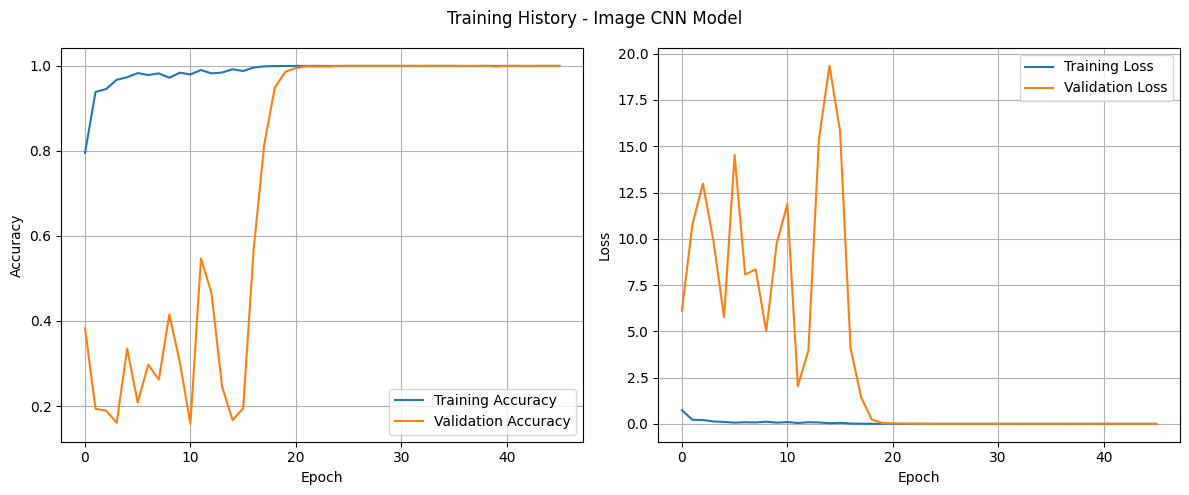


Hasil training model landmark:


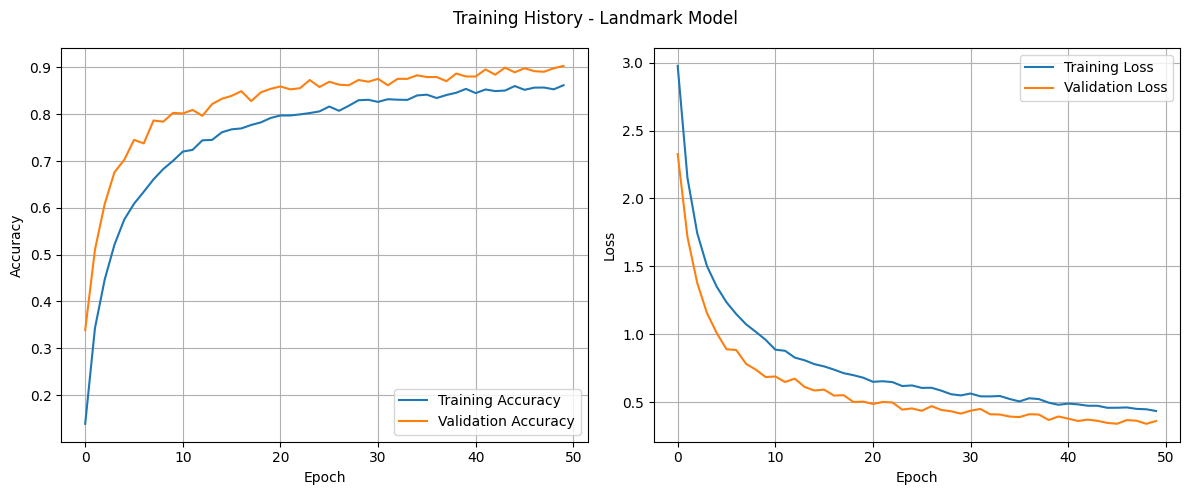


Hasil training model video:


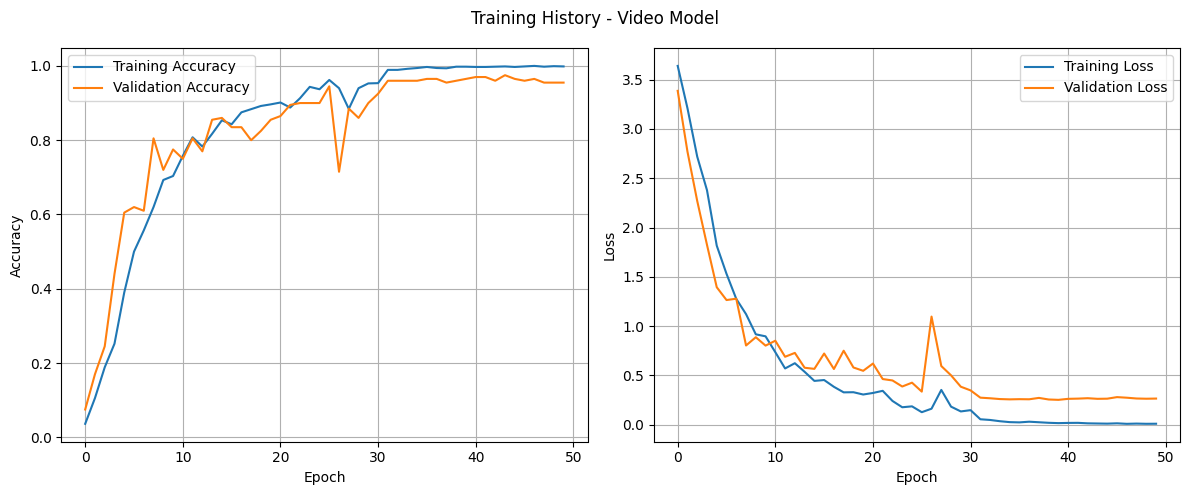

Evaluasi model CNN gambar:
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.9984 - loss: 0.0078
Test loss: 0.0091
Test accuracy: 0.9981

Evaluasi model landmark:
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8867 - loss: 0.3510
Test loss: 0.3560
Test accuracy: 0.8858

Evaluasi model video:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9566 - loss: 0.1755 
Test loss: 0.1917
Test accuracy: 0.9550
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step

Image CNN Model - Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.98      0.99        48
           B       1.00      1.00      1.00        65
           C       1.00      1.00      1.00        69
           D       1.00      1.00      1.00        75
           E       1.00      1.00      1.00        65
           F       1.00      1.00      1.00        64
           G       1.00      1.00      1.00        65
           H       1.00      1.00      1.00        56
           I

In [ ]:
# 6.1 Plot training history
def plot_training_history(history, title="Training History"):
    """
    Plot grafik training history

    Args:
        history: History object dari Keras
        title: Judul plot
    """
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Plot histories
print("Hasil training model CNN gambar:")
plot_training_history(image_history, "Training History - Image CNN Model")

print("\nHasil training model landmark:")
plot_training_history(landmark_history, "Training History - Landmark Model")

print("\nHasil training model video:")
plot_training_history(video_history, "Training History - Video Model")

# 6.2 Evaluasi model pada data test
print("Evaluasi model CNN gambar:")
image_evaluation = image_model.evaluate(X_test, y_test)
print(f"Test loss: {image_evaluation[0]:.4f}")
print(f"Test accuracy: {image_evaluation[1]:.4f}")

print("\nEvaluasi model landmark:")
landmark_evaluation = landmark_model.evaluate(X_landmarks_test, y_landmarks_test)
print(f"Test loss: {landmark_evaluation[0]:.4f}")
print(f"Test accuracy: {landmark_evaluation[1]:.4f}")

print("\nEvaluasi model video:")
video_evaluation = video_model.evaluate(X_video_test, y_video_test)
print(f"Test loss: {video_evaluation[0]:.4f}")
print(f"Test accuracy: {video_evaluation[1]:.4f}")

# 6.3 Confusion Matrix dan Classification Report
def evaluate_model(model, X_test, y_test, class_names, title="Model Evaluation"):
    """
    Evaluasi model dengan confusion matrix dan classification report

    Args:
        model: Model Keras yang ingin dievaluasi
        X_test: Data test
        y_test: Label test (one-hot encoded)
        class_names: Nama kelas
        title: Judul evaluasi
    """
    # Prediksi
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Classification report
    print(f"\n{title} - Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

    # Confusion Matrix (hanya tampilkan jika jumlah kelas < 20 untuk keterbacaan)
    if len(class_names) < 20:
        conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
        plt.figure(figsize=(10, 8))
        plt.imshow(conf_mat, cmap='Blues')
        plt.colorbar()
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'{title} - Confusion Matrix')

        # Tambahkan label
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)

        # Tambahkan nilai
        thresh = conf_mat.max() / 2
        for i in range(conf_mat.shape[0]):
            for j in range(conf_mat.shape[1]):
                plt.text(j, i, format(conf_mat[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if conf_mat[i, j] > thresh else "black")

        plt.tight_layout()
        plt.show()

# Evaluasi detail untuk setiap model
evaluate_model(image_model, X_test, y_test, class_names, "Image CNN Model")
evaluate_model(landmark_model, X_landmarks_test, y_landmarks_test, class_names, "Landmark Model")
evaluate_model(video_model, X_video_test, y_video_test, video_class_names, "Video Model")

## 7. Konversi Model untuk Deployment

In [ ]:
# 7.1 Save model dalam format HDF5
image_model.save('bisindo_image_model.h5')
landmark_model.save('bisindo_landmark_model.h5')
video_model.save('bisindo_video_model.h5')

# 7.2 Konversi ke TFLite untuk deployment mobile/web
def convert_to_tflite(model, model_name):
    """
    Konversi model Keras ke format TFLite

    Args:
        model: Model Keras
        model_name: Nama file output TFLite
    """
    # Konversi ke TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Added: Enable built-in TFLite operations and optimize
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    # Added: Explicitly disallow custom ops to force conversion to built-in if possible
    converter.allow_custom_ops = False

    try:
        tflite_model = converter.convert()

        # Simpan model
        with open(f'{model_name}.tflite', 'wb') as f:
            f.write(tflite_model)

        print(f"Model berhasil dikonversi dan disimpan sebagai {model_name}.tflite")

    except Exception as e:
        print(f"Error converting {model_name} to TFLite: {e}")
        print("Attempting conversion with allow_custom_ops=True (requires Flex delegate)")
        # Fallback to allowing custom ops if built-in conversion fails
        converter.allow_custom_ops = True
        try:
            tflite_model = converter.convert()
            with open(f'{model_name}_flex.tflite', 'wb') as f:
                f.write(tflite_model)
            print(f"Model berhasil dikonversi dan disimpan sebagai {model_name}_flex.tflite (using Flex delegate)")
        except Exception as flex_e:
            print(f"Error converting {model_name} even with Flex delegate: {flex_e}")


# Konversi setiap model ke TFLite
convert_to_tflite(image_model, 'bisindo_image_model')
convert_to_tflite(landmark_model, 'bisindo_landmark_model')
convert_to_tflite(video_model, 'bisindo_video_model')

Saved artifact at '/tmp/tmps088wnma'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_308')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  134222560518672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134222560522320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134225284937488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134222560518864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134222560510416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134225284937296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134220016534160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134220016534544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134225284935568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134225284936912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134220016

## 8. Inferensi Real-Time

In [ ]:
# 8.1 Fungsi inferensi untuk gambar
def predict_image(image_path, model=None, preprocessing_func=None, class_mapping=None):
    """
    Lakukan prediksi pada gambar input

    Args:
        image_path: Path ke gambar atau array gambar
        model: Model untuk prediksi
        preprocessing_func: Fungsi preprocessing (optional)
        class_mapping: Mapping indeks ke nama kelas

    Returns:
        predicted_class: Nama kelas prediksi
        confidence: Nilai confidence prediksi
    """
    # Load model jika tidak diberikan
    if model is None:
        model = keras.models.load_model('bisindo_image_model.h5')

    # Load class mapping jika tidak diberikan
    if class_mapping is None:
        with open('image_class_mapping.json', 'r') as f:
            class_mapping = json.load(f)

    # Load dan preprocess gambar
    if isinstance(image_path, str):
        image = cv2.imread(image_path)
    else:
        image = image_path

    if image is None:
        return "Error: Tidak dapat membaca gambar", 0.0

    # Resize gambar
    image = cv2.resize(image, (224, 224))

    # Ekstrak landmark tangan jika diperlukan
    if preprocessing_func:
        with mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5) as hands:
            landmarks_list, _ = extract_hand_landmarks(image, hands)

            if not landmarks_list:
                return "Tidak ada tangan terdeteksi", 0.0

            # Gunakan landmark sebagai input
            X = np.array([landmarks_list[0]])
    else:
        # Gunakan gambar sebagai input
        X = np.array([image / 255.0])

    # Prediksi
    prediction = model.predict(X)

    # Ambil kelas dengan probabilitas tertinggi
    predicted_class_idx = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class_idx]

    # Konversi indeks ke nama kelas
    predicted_class = class_mapping[str(predicted_class_idx)]

    return predicted_class, float(confidence)

# 8.2 Fungsi inferensi untuk video
def predict_video(video_path, model=None, class_mapping=None, num_frames=30):
    """
    Lakukan prediksi pada video input

    Args:
        video_path: Path ke video
        model: Model untuk prediksi
        class_mapping: Mapping indeks ke nama kelas
        num_frames: Jumlah frame yang diekstrak

    Returns:
        predicted_class: Nama kelas prediksi
        confidence: Nilai confidence prediksi
    """
    # Load model jika tidak diberikan
    if model is None:
        model = keras.models.load_model('bisindo_video_model.h5')

    # Load class mapping jika tidak diberikan
    if class_mapping is None:
        with open('video_class_mapping.json', 'r') as f:
            class_mapping = json.load(f)

    # Buka video
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return "Error: Tidak dapat membuka video", 0.0

    # Hitung jumlah frame
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Hitung interval untuk mengambil frame
    if total_frames <= num_frames:
        frame_indices = range(total_frames)
    else:
        frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)

    # Ekstrak landmark dari setiap frame
    video_landmarks_sequence = []

    with mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5) as hands:
        for frame_idx in range(total_frames):
            ret, frame = cap.read()

            if not ret:
                break

            if frame_idx in frame_indices:
                # Resize frame
                frame = cv2.resize(frame, (224, 224))

                # Ekstrak landmark
                landmarks_list, _ = extract_hand_landmarks(frame, hands)

                if landmarks_list:
                    # Gunakan landmark tangan pertama
                    video_landmarks_sequence.append(landmarks_list[0])
                else:
                    # Jika tidak ada landmark terdeteksi, gunakan zeros
                    video_landmarks_sequence.append(np.zeros(63))

    cap.release()

    # Pastikan sequence memiliki panjang yang sama dengan num_frames
    if len(video_landmarks_sequence) < num_frames:
        # Padding sequence
        padding = [np.zeros(63) for _ in range(num_frames - len(video_landmarks_sequence))]
        video_landmarks_sequence.extend(padding)
    elif len(video_landmarks_sequence) > num_frames:
        video_landmarks_sequence = video_landmarks_sequence[:num_frames]

    # Tambahkan dimensi batch
    X = np.array([video_landmarks_sequence])

    # Prediksi
    prediction = model.predict(X)

    # Ambil kelas dengan probabilitas tertinggi
    predicted_class_idx = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class_idx]

    # Konversi indeks ke nama kelas
    predicted_class = class_mapping[str(predicted_class_idx)]

    return predicted_class, float(confidence)

# 8.3 Inferensi real-time menggunakan webcam
def realtime_prediction():
    """
    Melakukan prediksi real-time menggunakan webcam

    Returns:
        None
    """
    # Load model dan class mapping
    try:
        landmark_model = keras.models.load_model('bisindo_landmark_model.h5')
        with open('image_class_mapping.json', 'r') as f:
            class_mapping = json.load(f)
    except:
        print("Error: Model atau class mapping tidak ditemukan. Pastikan model sudah dilatih dan disimpan.")
        return

    # Inisialisasi MediaPipe Hands
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    hands = mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=2,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5)

    # Buka webcam
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Tidak dapat mengakses webcam.")
        return

    # Inisialisasi variabel
    start_time = time.time()
    pred_class = ""
    confidence = 0.0
    frame_count = 0
    pred_interval = 10  # Prediksi setiap 10 frame

    while cap.isOpened():
        # Baca frame dari webcam
        ret, frame = cap.read()
        if not ret:
            print("Error: Tidak dapat membaca frame dari webcam.")
            break

        # Flip horizontal untuk tampilan mirror
        frame = cv2.flip(frame, 1)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Deteksi tangan
        results = hands.process(frame_rgb)

        # Gambar landmark tangan
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    frame,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())

            # Prediksi setiap pred_interval frame
            if frame_count % pred_interval == 0:
                landmarks_list = []
                for hand_landmarks in results.multi_hand_landmarks:
                    landmarks = []
                    for landmark in hand_landmarks.landmark:
                        landmarks.extend([landmark.x, landmark.y, landmark.z])
                    landmarks_list.append(landmarks)

                if landmarks_list:
                    # Prediksi menggunakan landmark model
                    X = np.array([landmarks_list[0]])
                    prediction = landmark_model.predict(X, verbose=0)
                    predicted_class_idx = np.argmax(prediction[0])
                    confidence = prediction[0][predicted_class_idx]
                    pred_class = class_mapping[str(predicted_class_idx)]

        # Tampilkan FPS
        current_time = time.time()
        fps = 1 / (current_time - start_time) if (current_time - start_time) > 0 else 0
        start_time = current_time

        # Tampilkan hasil prediksi pada frame
        cv2.putText(frame, f"FPS: {fps:.1f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, f"Prediksi: {pred_class}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, f"Confidence: {confidence:.2f}", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Tampilkan frame
        cv2.imshow("BISINDO Sign Language Translator", frame)

        # Keluar dengan menekan 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_count += 1

    # Clean up
    cap.release()
    cv2.destroyAllWindows()
    hands.close()

## 9. Implementasi API Sederhana dengan Flask

In [ ]:
# 9.1 API Flask untuk prediksi gambar dan video
def create_flask_api():
    """
    Buat API sederhana dengan Flask
    """
    from flask import Flask, request, jsonify
    from werkzeug.utils import secure_filename
    import os

    app = Flask(__name__)
    app.config['UPLOAD_FOLDER'] = 'uploads'
    os.makedirs(app.config['UPLOAD_FOLDER'], exist_ok=True)

    # Load model dan class mapping
    image_model = keras.models.load_model('bisindo_image_model.h5')
    landmark_model = keras.models.load_model('bisindo_landmark_model.h5')
    video_model = keras.models.load_model('bisindo_video_model.h5')

    with open('image_class_mapping.json', 'r') as f:
        image_class_mapping = json.load(f)

    with open('video_class_mapping.json', 'r') as f:
        video_class_mapping = json.load(f)

    @app.route('/')
    def home():
        return """
        <h1>BISINDO Sign Language Translator API</h1>
        <p>API sederhana untuk menerjemahkan Bahasa Isyarat Indonesia (BISINDO)</p>
        <h2>Endpoint:</h2>
        <ul>
            <li>POST /predict_image - Prediksi dari gambar</li>
            <li>POST /predict_video - Prediksi dari video</li>
        </ul>
        """

    @app.route('/predict_image', methods=['POST'])
    def api_predict_image():
        if 'file' not in request.files:
            return jsonify({'error': 'Tidak ada file yang diunggah'}), 400

        file = request.files['file']
        if file.filename == '':
            return jsonify({'error': 'Tidak ada file yang dipilih'}), 400

        if file:
            filename = secure_filename(file.filename)
            filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            file.save(filepath)

            # Prediksi
            try:
                predicted_class, confidence = predict_image(
                    filepath, model=image_model, class_mapping=image_class_mapping)

                return jsonify({
                    'predicted_class': predicted_class,
                    'confidence': confidence
                })
            except Exception as e:
                return jsonify({'error': str(e)}), 500

    @app.route('/predict_video', methods=['POST'])
    def api_predict_video():
        if 'file' not in request.files:
            return jsonify({'error': 'Tidak ada file yang diunggah'}), 400

        file = request.files['file']
        if file.filename == '':
            return jsonify({'error': 'Tidak ada file yang dipilih'}), 400

        if file:
            filename = secure_filename(file.filename)
            filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            file.save(filepath)

            # Prediksi
            try:
                predicted_class, confidence = predict_video(
                    filepath, model=video_model, class_mapping=video_class_mapping)

                return jsonify({
                    'predicted_class': predicted_class,
                    'confidence': confidence
                })
            except Exception as e:
                return jsonify({'error': str(e)}), 500

    # Jalankan server Flask
    # Change the port to something else, e.g., 8081, 5000, etc.
    # Make sure to pick a port that is not commonly used.
    app.run(host='0.0.0.0', port=8081) # Changed port to 8081

# Fungsi ini akan menjalankan Flask API di Colab
create_flask_api()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8081
 * Running on http://172.28.0.12:8081
INFO:werkzeug:Press CTRL+C to quit


## 10. Demo UI dengan Gradio

In [ ]:
def create_gradio_ui():
    """
    Buat UI demo dengan Gradio (versi terbaru)
    """
    # Load model dan class mapping
    try:
        image_model = keras.models.load_model('bisindo_image_model.h5')
        landmark_model = keras.models.load_model('bisindo_landmark_model.h5')
        video_model = keras.models.load_model('bisindo_video_model.h5')

        with open('image_class_mapping.json', 'r') as f:
            image_class_mapping = json.load(f)

        with open('video_class_mapping.json', 'r') as f:
            video_class_mapping = json.load(f)
    except Exception as e:
        print(f"Error loading models: {str(e)}")
        return

    # Fungsi prediksi gambar
    def predict_from_image(image):
        if image is None:
            return "Tidak ada gambar yang diunggah", None

        try:
            image_np = np.array(image)
            image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

            with mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5) as hands:
                landmarks_list, processed_img = extract_hand_landmarks(image_bgr, hands)

            if not landmarks_list:
                return "Tidak ada tangan terdeteksi", cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

            X = np.array([landmarks_list[0]])
            prediction = landmark_model.predict(X, verbose=0)
            predicted_class_idx = np.argmax(prediction[0])
            confidence = prediction[0][predicted_class_idx]
            pred_class = image_class_mapping[str(predicted_class_idx)]

            return f"Prediksi: {pred_class} (Confidence: {confidence:.2f})", cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)
        except Exception as e:
            return f"Error: {str(e)}", None

    # Fungsi prediksi webcam
    def predict_from_webcam(image):
        return predict_from_image(image)

    # Fungsi prediksi video
    def predict_from_video(video_path):
        if video_path is None:
            return "Tidak ada video yang diunggah"

        try:
            with mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5) as hands:
                predicted_class, confidence = predict_video(video_path, model=video_model,
                                                          class_mapping=video_class_mapping,
                                                          hands_detector=hands)
            return f"Prediksi: {predicted_class} (Confidence: {confidence:.2f})"
        except Exception as e:
            return f"Error: {str(e)}"

    # Fungsi teks ke isyarat
    def text_to_sign(text):
        if not text:
            return "Masukkan teks untuk diterjemahkan"

        try:
            words = text.lower().split()
            all_classes = set()

            with open('image_class_mapping.json', 'r') as f:
                img_map = json.load(f)
                all_classes.update(v.lower() for v in img_map.values())

            with open('video_class_mapping.json', 'r') as f:
                video_map = json.load(f)
                all_classes.update(v.lower() for v in video_map.values())

            found = [w for w in words if w in all_classes]
            not_found = [w for w in words if w not in all_classes]

            result = f"Kata yang ditemukan: {', '.join(found)}" if found else "Tidak ada kata yang ditemukan"
            if not_found:
                result += f"\nKata tidak dikenal: {', '.join(not_found)}"

            return result
        except Exception as e:
            return f"Error: {str(e)}"

    # Buat interface Gradio
    with gr.Blocks(title="BISINDO Translator") as demo:
        gr.Markdown("# Artisign")

        with gr.Tabs():
            with gr.Tab("Gambar"):
                with gr.Row():
                    img_input = gr.Image(label="Upload Gambar")
                    img_button = gr.Button("Terjemahkan")
                with gr.Row():
                    img_output = gr.Text(label="Hasil")
                    img_vis = gr.Image(label="Landmark")
                img_button.click(predict_from_image, inputs=img_input, outputs=[img_output, img_vis])

            with gr.Tab("Webcam"):
                with gr.Row():
                    webcam = gr.Image(label="Kamera", streaming=True)
                    webcam_button = gr.Button("Terjemahkan")
                with gr.Row():
                    webcam_output = gr.Text(label="Hasil")
                    webcam_vis = gr.Image(label="Landmark")
                webcam_button.click(predict_from_webcam, inputs=webcam, outputs=[webcam_output, webcam_vis])

            with gr.Tab("Video"):
                with gr.Row():
                    video = gr.Video(label="Upload Video")
                    video_button = gr.Button("Terjemahkan")
                video_output = gr.Text(label="Hasil")
                video_button.click(predict_from_video, inputs=video, outputs=video_output)

            with gr.Tab("Teks ke Isyarat"):
                with gr.Row():
                    text = gr.Textbox(label="Masukkan Teks")
                    text_button = gr.Button("Cari")
                text_output = gr.Text(label="Hasil")
                text_button.click(text_to_sign, inputs=text, outputs=text_output)

        gr.Markdown("""
        ### Cara Penggunaan:
        1. **Gambar**: Unggah foto isyarat tangan
        2. **Webcam**: Gunakan kamera real-time
        3. **Video**: Unggah video isyarat
        4. **Teks**: Cari isyarat untuk kata tertentu
        """)

    demo.launch(share=True)

create_gradio_ui()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5efdf16885d0ee343a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# komen

menurut saya ini sudah aman mas untuk modelnya,ditambah lagi precisionnya rata-rata sudah bagus semua dan hanya sedikit yang di bawah 80% precisionnya itu saja dari saya mas.bebas dari masnya kalau menambahkan model lain lagi

```
ha